In [1]:
import pandas as pd
from igraph import Graph
import igraph
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
import numpy as np
import stellargraph as sg
import pickle

/home/jhpark/anaconda3/envs/jeongha/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import GraphSAGELinkGenerator,GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from tensorflow import keras
import time
from collections import defaultdict

In [3]:
defaultVal = 1
incentiveVal = 1
penaltyVal = 1
# 극대화

In [4]:
# Edge between two user node (607,333 friendships)
file = '/home/jhpark/dataset/dataset_WWW_friendship_new.txt'
g = nx.read_edgelist(file , nodetype = int, edgetype='Freindship')

In [5]:
ig = Graph.from_networkx(g) # NetworkX to igraph 
ig.vs["id"] = ig.vs["_nx_name"]
ig.es["weight"] = [defaultVal]*ig.ecount()

In [6]:
# METIS Partitioning !!!!
import pymetis
adjlist = []
for line in nx.generate_adjlist(g):
    adjlist.append([line])
    
for i in range(len(adjlist)):
    adjlist[i] = list(map(int,adjlist[i][0].split()))

ModuleNotFoundError: No module named 'pymetis'

In [45]:
# Adjlist index 안맞아서 전처리함
nodes = []
for el in adjlist:
    nodes.append(el[0])
    
nodes_dict = {k: v for v, k in enumerate(nodes)}

for i in range(len(adjlist)):
    for j in range(len(adjlist[i])):
        adjlist[i][j] = nodes_dict[adjlist[i][j]]

In [ ]:
k = 50
partitioned = pymetis.part_graph(k, adjacency=adjlist)

membership = partitioned[1]
Counter(membership)

In [7]:
node_features_encoded = pd.read_csv("/home/jhpark/dataset/node_features_encoded.csv", index_col=0)

In [8]:
node_features_encoded

,userID,latitude,longitude,degree,countrycode_encoded,category_encoded
0,15,36.292778,-119.332032,1,136,179
1,595326,36.330163,-119.292760,2,136,30
2,19,40.725292,-73.989419,21,136,3
3,54,37.781213,-122.402973,12,136,369
4,1061,37.761245,-122.402169,4,136,369
...,...,...,...,...,...,...
114319,2110586,41.015145,29.082438,1,130,311
114320,2112106,40.977817,28.869099,1,130,237
114321,2112150,1.349318,103.746295,1,122,199
114322,2127581,1.309555,103.778610,1,122,237


In [9]:
country_degree = pd.concat([node_features_encoded['countrycode_encoded'], node_features_encoded['degree']],axis=1)

In [10]:
userGraph_country_deg = StellarGraph.from_networkx(ig.to_networkx(), node_type_default = "user", edge_type_default = "friendship", node_features = country_degree)

In [11]:
print(userGraph_country_deg.info()) # 전체 그래프 load

StellarGraph: Undirected multigraph
 Nodes: 114324, Edges: 607333

 Node types:
  user: [114324]
    Features: float32 vector, length 2
    Edge types: user-friendship->user

 Edge types:
    user-friendship->user: [607333]
        Weights: all 1 (default)
        Features: none


In [12]:
def graphsage_learning(edge_splitter_test,graph):
    # Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
    # reduced graph G_test with the sampled links removed:
    G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
        p=0.1, method="global", keep_connected=True
    )

    # Define an edge splitter on the reduced graph G_test:
    edge_splitter_train = EdgeSplitter(G_test)

    # Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
    # reduced graph G_train with the sampled links removed:
    G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
        p=0.1, method="global", keep_connected=True
    )

    train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples, weighted =True)
    train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)
    test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples, weighted =True)
    test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

    graphsage = GraphSAGE(
        layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
    )

    x_inp, x_out = graphsage.in_out_tensors()

    prediction = link_classification(
        output_dim=1, output_act="relu", edge_embedding_method="ip"
    )(x_out)

    model = keras.Model(inputs=x_inp, outputs=prediction)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=["acc"],
    )

    init_train_metrics = model.evaluate(train_flow)
    init_test_metrics = model.evaluate(test_flow)

    print("\nTrain Set Metrics of the initial (untrained) model:")
    for name, val in zip(model.metrics_names, init_train_metrics):
        print("\t{}: {:0.4f}".format(name, val))

    print("\nTest Set Metrics of the initial (untrained) model:")
    for name, val in zip(model.metrics_names, init_test_metrics):
        print("\t{}: {:0.4f}".format(name, val))

    print()
    print("#################################################################################################################")

    history = model.fit(train_flow, epochs=10, validation_data=test_flow, verbose=2)
    
    import stellargraph as sg
    sg.utils.plot_history(history)
    with open('/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


    print()
    print("################################################################################################################")

    train_metrics = model.evaluate(train_flow)
    test_metrics = model.evaluate(test_flow)

    print("\nTrain Set Metrics of the trained model:")
    for name, val in zip(model.metrics_names, train_metrics):
        print("\t{}: {:0.4f}".format(name, val))

    print("\nTest Set Metrics of the trained model:")
    for name, val in zip(model.metrics_names, test_metrics):
        print("\t{}: {:0.4f}".format(name, val))

    x_inp_src = x_inp[0::2]
    x_out_src = x_out[0]
    embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)
    
    node_ids = graph.nodes()
    node_gen = GraphSAGENodeGenerator(graph, batch_size, num_samples).flow(node_ids)
    node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)
    
    return node_embeddings


In [12]:
'''# Baseline Experiment #
start = time.time()
edge_splitter_test = EdgeSplitter(userGraph_country_deg)
baseline_emb = graphsage_learning(edge_splitter_test,userGraph_country_deg)
print("time :", time.time() - start) '''

'# Baseline Experiment #\nstart = time.time()\nedge_splitter_test = EdgeSplitter(userGraph_country_deg)\nbaseline_emb = graphsage_learning(edge_splitter_test,userGraph_country_deg)\nprint("time :", time.time() - start) '

### 1. Community 단위로 RL 적용 (local RL) - 병렬 처리 가능

In [13]:
LP = Graph.community_label_propagation(ig)

In [14]:
cd_algo = LP

In [15]:
size_thresh = 100

In [16]:
minor_nodes_num = 0
major_comm_num = 0
for i in cd_algo:
    if len(i)<=size_thresh: 
        minor_nodes_num += len(i)
    else:
        major_comm_num += 1
print("100보다 작은 커뮤니티의 노드 수: ", minor_nodes_num)
print("100보다 큰 커뮤니티 개수: ", major_comm_num)
print("Reduced graph 노드 수: ",major_comm_num+minor_nodes_num)

100보다 작은 커뮤니티의 노드 수:  25173
100보다 큰 커뮤니티 개수:  82
Reduced graph 노드 수:  25255


In [17]:
# GraphSAGE Hyper-parameter Settings
batch_size = 20
epochs = 10
num_samples = [20, 10]
layer_sizes = [50, 50]

In [18]:
def subGraphSAGE(subgraphList):
    subgraph = ig.induced_subgraph(subgraphList,implementation="create_from_scratch")
    
    isin_filter = node_features_encoded['userID'].isin(subgraph.vs['id'])
    
    subgraph_features = node_features_encoded[isin_filter]
    subgraph_country_degree = pd.concat([subgraph_features['countrycode_encoded'], subgraph_features['degree']],axis=1)
    subgraph_country_degree.reset_index(drop=True,inplace=True)
    
    subgraph_ = StellarGraph.from_networkx(subgraph.to_networkx(), node_type_default = "user", edge_type_default = "friendship", node_features = subgraph_country_degree)
   
    subnodes = list(subgraph_.nodes())
    sub_unsupervised_samples = UnsupervisedSampler(
        subgraph_, nodes = subnodes, length=5, number_of_walks=1
    )
    
    sub_generator = GraphSAGELinkGenerator(subgraph_, batch_size, num_samples)
    sub_train_gen = sub_generator.flow(sub_unsupervised_samples)
    
    sub_graphsage = GraphSAGE(
        layer_sizes = layer_sizes, generator=sub_generator, bias=True, dropout=0.0, normalize="l2"
    )
    
    x_inp, x_out = sub_graphsage.in_out_tensors()
    x_inp_src = x_inp[0::2]
    x_out_src = x_out[0]
    sub_embedding_model = keras.Model(inputs = x_inp_src, outputs = x_out_src)
    
    sub_node_ids = subgraph_.nodes()
    sub_node_gen = GraphSAGENodeGenerator(subgraph_, batch_size, num_samples).flow(sub_node_ids)
    
    sub_node_embeddings = sub_embedding_model.predict(sub_node_gen, workers=4, verbose=1)
    
    return sub_node_embeddings

In [19]:
node_embeddings = defaultdict(lambda: np.zeros(dimensions)) # Initialization

In [21]:
start = time.time()
for community_no in range(len(cd_algo)):
    # Intra Community Embedding 
    if len(cd_algo[community_no]) >= size_thresh:
        sub_node_embeddings = subGraphSAGE(cd_algo[community_no])
        print(len(sub_node_embeddings))
        
        # 전체 그래프에 대한 GraphSAGE에 의해 도출된 feature를 아예 덮어쓰는 것. 
        j=0
        for i in cd_algo[community_no]:
            node_embeddings[i] = sub_node_embeddings[j]
            j += 1
print("time(local) :", time.time() - start) 

744/744 [==============================] - 29s 38ms/step
14877
87/87 [==============================] - 3s 33ms/step
1733
13/13 [==============================] - 1s 20ms/step
258
110/110 [==============================] - 4s 38ms/step
2189
48/48 [==============================] - 2s 38ms/step
945
21/21 [==============================] - 1s 36ms/step
414
208/208 [==============================] - 8s 37ms/step
4158
6/6 [==============================] - 0s 5ms/step
116
8/8 [==============================] - 0s 35ms/step
146
6/6 [==============================] - 0s 10ms/step
102
6/6 [==============================] - 0s 11ms/step
101
370/370 [==============================] - 16s 43ms/step
7391
354/354 [==============================] - 15s 42ms/step
7066
574/574 [==============================] - 21s 36ms/step
11466
41/41 [==============================] - 2s 34ms/step
801
7/7 [==============================] - 0s 4ms/step
127
13/13 [==============================] - 1s 32ms/step
248
3

KeyboardInterrupt: 

### Community는 하나의 node로 변환함으로써 축소된 Global graph 생성

In [ ]:
membership = cd_algo.membership
counter = Counter(membership).most_common()

In [ ]:
minor_vertexID = []
# community size 가 100보다 작으면 minor vertex ID list에 추가
for c in counter:
    if c[1]<size_thresh:
        minor_vertexID.append(c[0])
print(len(minor_vertexID))

In [ ]:
# Minor community 인 애들은 노드 살려놔야하니까 membership 다시 부여하기
new_id = len(cd_algo)
for i in range(len(membership)):
    if membership[i] in minor_vertexID:
        membership[i] = new_id
        new_id += 1

In [ ]:
idx_map = {}
n = 0
for i in sorted(dict(Counter(membership))):
    idx_map[i] = n
    n+=1

In [ ]:
# 인덱스 순서대로 초기화
new_idx = 0
for i in range(len(membership)):
    membership[i] = idx_map[membership[i]]

In [ ]:
ig.contract_vertices(membership, combine_attrs="first") # mean이나 median으로 하면 node id까지 반영되서 isin에서 노드 수가 달라져서 실행이 안됨.. 

In [58]:
isin_filter = node_features_encoded['userID'].isin(ig.vs['_nx_name'])
subgraph_features = node_features_encoded[isin_filter]

In [59]:
subgraph_country_degree = pd.concat([subgraph_features['countrycode_encoded'], subgraph_features['degree']],axis=1)
subgraph_country_degree.reset_index(drop=True,inplace=True)

In [60]:
len(subgraph_country_degree)

25722

In [61]:
len(ig.to_networkx().nodes)

25722

### RL 적용 (global RL) - 기존 graph에 비해 연산 크게 축소

In [62]:
reduced_globalG = StellarGraph.from_networkx(ig.to_networkx(), node_type_default = "user", edge_type_default = "friendship", node_features = subgraph_country_degree)
print(reduced_globalG.info()) # 전체 그래프 load

StellarGraph: Undirected multigraph
 Nodes: 25722, Edges: 607333

 Node types:
  user: [25722]
    Features: float32 vector, length 2
    Edge types: user-friendship->user

 Edge types:
    user-friendship->user: [607333]
        Weights: all 1 (default)
        Features: none


** Sampled 60733 positive and 60733 negative edges. **
** Sampled 54660 positive and 54660 negative edges. **
link_classification: using 'ip' method to combine node embeddings into edge embeddings
6074/6074 [==============================] - 1307s 215ms/step - loss: 1.9668 - acc: 0.5007

Train Set Metrics of the initial (untrained) model:
	loss: 1.9515
	acc: 0.5008

Test Set Metrics of the initial (untrained) model:
	loss: 1.9668
	acc: 0.5007

#################################################################################################################
Epoch 1/10
5466/5466 - 2331s - loss: 0.5121 - acc: 0.7495 - val_loss: 0.5084 - val_acc: 0.7841
Epoch 2/10
5466/5466 - 2322s - loss: 0.4495 - acc: 0.7963 - val_loss: 0.4574 - val_acc: 0.8099
Epoch 3/10
5466/5466 - 2335s - loss: 0.4247 - acc: 0.8175 - val_loss: 0.4296 - val_acc: 0.8018
Epoch 4/10
5466/5466 - 2331s - loss: 0.3994 - acc: 0.8304 - val_loss: 0.4226 - val_acc: 0.8158
Epoch 5/10
5466/5466 - 2339s - loss: 0.3843 - acc: 0.8397 

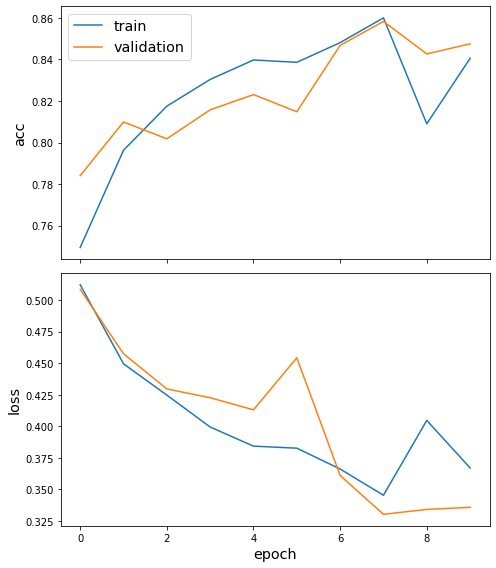

In [63]:
start = time.time()
edge_splitter_test = EdgeSplitter(reduced_globalG)
reudced_emb = graphsage_learning(edge_splitter_test,reduced_globalG)
print("Global GRL time :", time.time() - start)

In [64]:
# MERGE Final Results
j = 0
for community_no in range(len(cd_algo)):
    # Intra Community Embedding   
    if len(cd_algo[community_no]) < size_thresh: # Minor community 에 대한 노드들은 global GRL에서 결과 가져오기
        for i in cd_algo[community_no]:
            node_embeddings[i] = reudced_emb[j]
            j += 1
    else: # reduced node는 하나로 변환
        j += 1           
j

25722

In [65]:
len(node_embeddings)

114324

In [35]:
'''
node_embeddings + reudced_emb = node features 만들어서
graph 생성 -> GraphSAGE Link prediction
* reudced_emb : 인덱스 보고 어떻게 전체 그래프 node feature랑 맞게 합칠지 고민해보기 
'''

'\nnode_embeddings + reudced_emb = node features 만들어서\ngraph 생성 -> GraphSAGE Link prediction\n* reudced_emb : 인덱스 보고 어떻게 전체 그래프 node feature랑 맞게 합칠지 고민해보기 \n'

### Downstream Task

In [66]:
node_embeddings_df = pd.DataFrame(node_embeddings).transpose()

In [67]:
node_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.057778,0.046079,-0.010340,-0.004837,0.057117,0.202719,-0.121175,0.106275,0.060493,-0.085984,...,-0.194124,-0.100204,-0.391002,0.011303,0.247806,0.075538,0.003518,0.003709,0.163190,0.073000
1,0.070816,-0.050930,0.021478,-0.059246,0.072575,0.197167,-0.129543,0.066938,0.051237,-0.101927,...,-0.193578,-0.079410,-0.359469,0.010079,0.271591,0.132288,0.009367,0.016135,0.182541,0.082338
2,0.082630,0.053930,-0.026518,0.000330,0.035464,0.197917,-0.104299,0.115819,0.070591,-0.103364,...,-0.196641,-0.077319,-0.381830,0.002032,0.256920,0.091161,0.023162,-0.015112,0.175457,0.060558
3,0.075126,0.031178,-0.012940,-0.013213,0.049133,0.202211,-0.115493,0.105044,0.065109,-0.100167,...,-0.195443,-0.091133,-0.381731,0.009304,0.257792,0.097497,0.011655,-0.003984,0.170208,0.070475
4,0.068647,0.021315,-0.004027,-0.020244,0.061680,0.212278,-0.128207,0.102155,0.062817,-0.098142,...,-0.184648,-0.097418,-0.382592,0.010027,0.246008,0.097030,-0.014007,0.001092,0.148819,0.077259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114314,0.081989,-0.161314,0.034425,-0.030347,0.024295,-0.105273,0.011098,0.000107,0.077911,-0.062624,...,0.429103,-0.268716,0.097612,0.167885,0.138646,-0.262580,-0.356906,-0.143936,-0.069616,-0.034607
114315,0.081989,-0.161314,0.034425,-0.030347,0.024295,-0.105273,0.011098,0.000107,0.077911,-0.062624,...,0.429103,-0.268716,0.097612,0.167885,0.138646,-0.262580,-0.356906,-0.143936,-0.069616,-0.034607
114316,0.081989,-0.161314,0.034425,-0.030347,0.024295,-0.105273,0.011098,0.000107,0.077911,-0.062624,...,0.429103,-0.268716,0.097612,0.167885,0.138646,-0.262580,-0.356906,-0.143936,-0.069616,-0.034607
114321,0.102317,-0.123077,0.024957,-0.008173,0.038960,-0.090908,0.018965,0.007755,0.047456,-0.070038,...,0.375758,-0.189835,0.008301,0.085319,0.140151,-0.230194,-0.258755,-0.272882,-0.020238,-0.037737


In [68]:
ig = Graph.from_networkx(g) # NetworkX to igraph 
ig.vs["id"] = ig.vs["_nx_name"]
ig.es["weight"] = [defaultVal]*ig.ecount()

In [69]:
merged_Graph = StellarGraph.from_networkx(ig.to_networkx(), node_type_default = "user", edge_type_default = "friendship", node_features = node_embeddings_df)

** Sampled 60733 positive and 60733 negative edges. **
** Sampled 54660 positive and 54660 negative edges. **
link_classification: using 'ip' method to combine node embeddings into edge embeddings
6074/6074 [==============================] - 300s 49ms/step - loss: 0.4359 - acc: 0.8032

Train Set Metrics of the initial (untrained) model:
	loss: 0.4362
	acc: 0.8029

Test Set Metrics of the initial (untrained) model:
	loss: 0.4359
	acc: 0.8032

#################################################################################################################
Epoch 1/10
5466/5466 - 514s - loss: 0.2744 - acc: 0.9191 - val_loss: 0.2406 - val_acc: 0.9348
Epoch 2/10
5466/5466 - 515s - loss: 0.2135 - acc: 0.9361 - val_loss: 0.2058 - val_acc: 0.9443
Epoch 3/10
5466/5466 - 514s - loss: 0.1835 - acc: 0.9433 - val_loss: 0.1947 - val_acc: 0.9442
Epoch 4/10
5466/5466 - 513s - loss: 0.1722 - acc: 0.9462 - val_loss: 0.1762 - val_acc: 0.9507
Epoch 5/10
5466/5466 - 513s - loss: 0.1645 - acc: 0.9485 - val_l

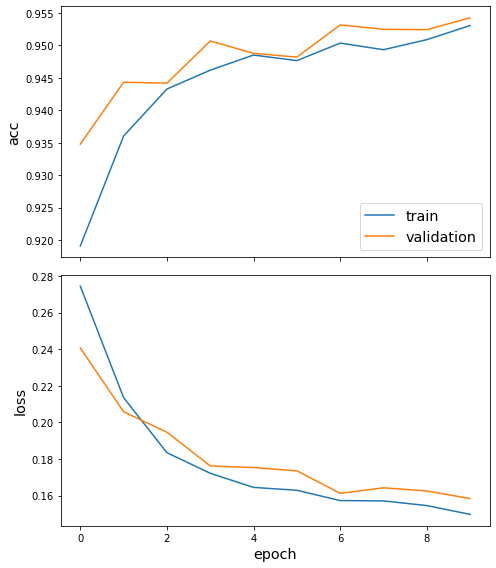

In [70]:
start = time.time()
edge_splitter_test = EdgeSplitter(merged_Graph)
graphsage_learning(edge_splitter_test, merged_Graph)
print("time(global) :", time.time() - start) 

igraph.Vertex(<igraph.Graph object at 0x7fda593527c8>, 1, {'_nx_name': 595326, 'id': 595326})